In [61]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from slsim.Observations.roman_speclite import configure_roman_filters
from slsim.Observations.roman_speclite import filter_names
import speclite.filters
import matplotlib.patches as mpatches
import scipy
from phrosty import plotting

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs
from mejiro.instruments.roman import Roman

In [62]:
save_dir = os.path.join(config.machine.data_dir, 'output', 'lowest_detectable_subhalo_mass')
results = util.unpickle_all(save_dir, 'results_', '.pkl')

In [63]:
pprint(results[0].keys())

dict_keys(['1_511_511', '1_511_1533', '1_511_2555', '1_511_3577', '1_1533_511', '1_1533_1533', '1_1533_2555', '1_1533_3577', '1_2555_511', '1_2555_1533', '1_2555_2555', '1_2555_3577', '1_3577_511', '1_3577_1533', '1_3577_2555', '1_3577_3577', '2_511_511', '2_511_1533', '2_511_2555', '2_511_3577', '2_1533_511', '2_1533_1533', '2_1533_2555', '2_1533_3577', '2_2555_511', '2_2555_1533', '2_2555_2555', '2_2555_3577', '2_3577_511', '2_3577_1533', '2_3577_2555', '2_3577_3577', '3_511_511', '3_511_1533', '3_511_2555', '3_511_3577', '3_1533_511', '3_1533_1533', '3_1533_2555', '3_1533_3577', '3_2555_511', '3_2555_1533', '3_2555_2555', '3_2555_3577', '3_3577_511', '3_3577_1533', '3_3577_2555', '3_3577_3577', '4_511_511', '4_511_1533', '4_511_2555', '4_511_3577', '4_1533_511', '4_1533_1533', '4_1533_2555', '4_1533_3577', '4_2555_511', '4_2555_1533', '4_2555_2555', '4_2555_3577', '4_3577_511', '4_3577_1533', '4_3577_2555', '4_3577_3577', '5_511_511', '5_511_1533', '5_511_2555', '5_511_3577', '5_153

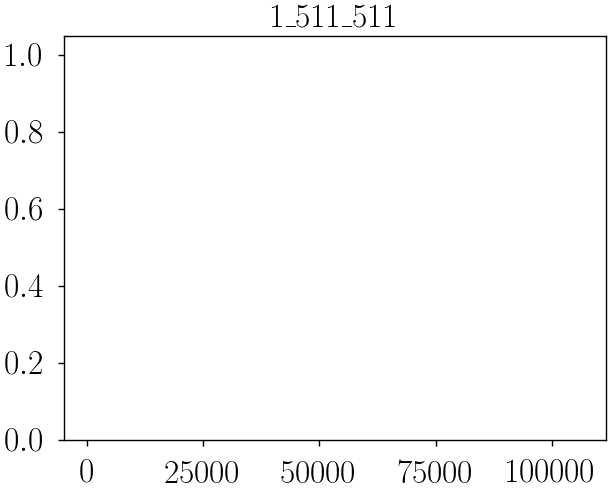

In [64]:
sample_position_key = list(results[0].keys())[0]
sample_results = results[0][sample_position_key]

mass_list, median_list, maxes, mins = [], [], [], []
for mass, chi_squared_list in sample_results.items():
    mass_list.append(mass)
    median_list.append(np.median(chi_squared_list))
    maxes.append(np.max(chi_squared_list))
    mins.append(np.min(chi_squared_list))
    if all(v == 0 for v in chi_squared_list):
        plt.axvline(0, label=f'{float(mass):.0e} M$_\odot$')
    else:
        plt.hist(chi_squared_list, label=f'{float(mass):.0e} M$_\odot$', alpha=0.5, bins=5)

uplims = np.array(maxes) - np.array(median_list)
lolims = np.array(median_list) - np.array(mins)

# plt.xscale('log')
plt.title(sample_position_key)
# plt.legend()
plt.savefig(os.path.join(figure_dir, 'ldsm_01_histogram.png'))
plt.show()

In [65]:
from scipy.stats import chi2

pixels = 42 ** 2
df = pixels - 3  # 3 dof: subhalo x, subhalo y, subhalo mass

rv = chi2(df)

pval_threshold = 0.001  # three sigma

chi2_list = np.linspace(1950, 1951, 100)
for chi in chi2_list:
    pval = rv.sf(chi)
    if pval < pval_threshold:
        print(f'chi2: {chi:.2f}, pval: {pval:.2e}')
        break

chi2: 1950.11, pval: 1.00e-03


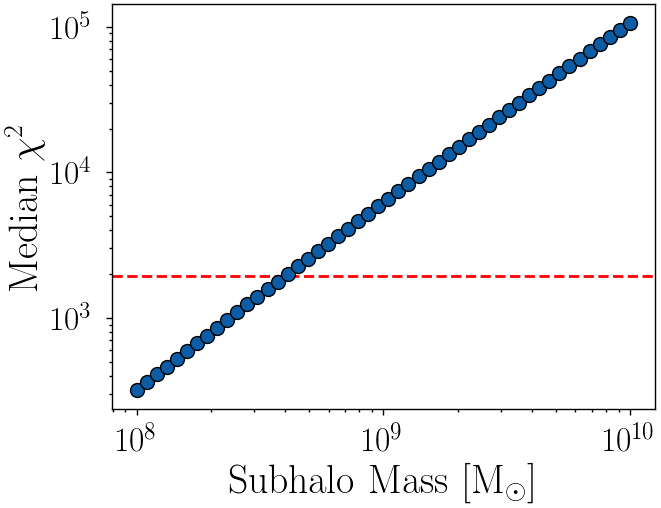

In [66]:
mass_list = [float(mass) for mass in mass_list]
plt.errorbar(mass_list, median_list, yerr=[uplims, lolims], fmt='o')
plt.axhline(1950.11, color='r', linestyle='--', label=f'3$\sigma$')
plt.xlabel('Subhalo Mass [M$_\odot$]')
plt.ylabel('Median $\chi^2$')
plt.xscale('log')
plt.yscale('log')
plt.savefig(os.path.join(figure_dir, 'ldsm_02_errorbar.png'))
plt.show()

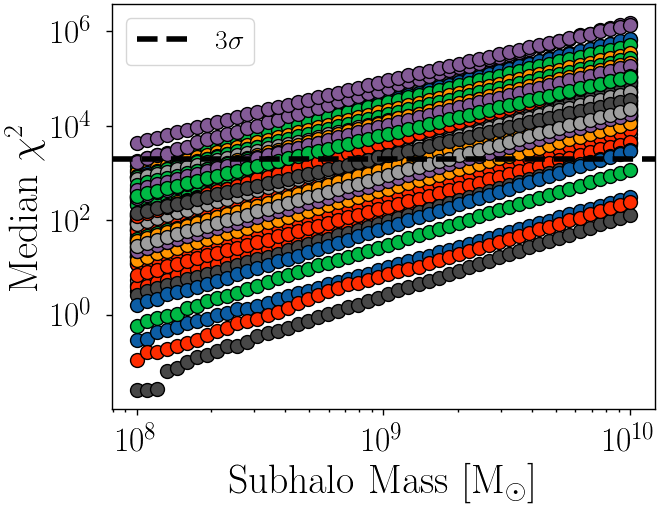

In [67]:
sample_position_key = list(results[0].keys())[0]

for i, result in enumerate(results):
    sample_results = result[sample_position_key]

    mass_list, median_list, maxes, mins = [], [], [], []
    for mass, chi_squared_list in sample_results.items():
        mass_list.append(mass)
        median_list.append(np.median(chi_squared_list))
        maxes.append(np.max(chi_squared_list))
        mins.append(np.min(chi_squared_list))
        uplims = np.array(maxes) - np.array(median_list)
        lolims = np.array(median_list) - np.array(mins)

    mass_list = [float(mass) for mass in mass_list]
    plt.errorbar(mass_list, median_list, yerr=[lolims, uplims], fmt='o')  # , label=f'Lens {i + 1}', ls='-'
plt.axhline(1950.11, color='black', linestyle='--', label=f'3$\sigma$', zorder=1e3, lw=4)
plt.xlabel('Subhalo Mass [M$_\odot$]')
plt.ylabel('Median $\chi^2$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig(os.path.join(figure_dir, 'ldsm_03_lenses.png'))
plt.show()

Skipping lens 7
Skipping lens 12
Skipping lens 14
Skipping lens 19
Skipping lens 22
Skipping lens 25
Skipping lens 26
Skipping lens 27
Skipping lens 31
Skipping lens 43
Skipping lens 44
Skipping lens 45
Skipping lens 48
Skipping lens 50
Skipping lens 57
Skipping lens 66
Skipping lens 67


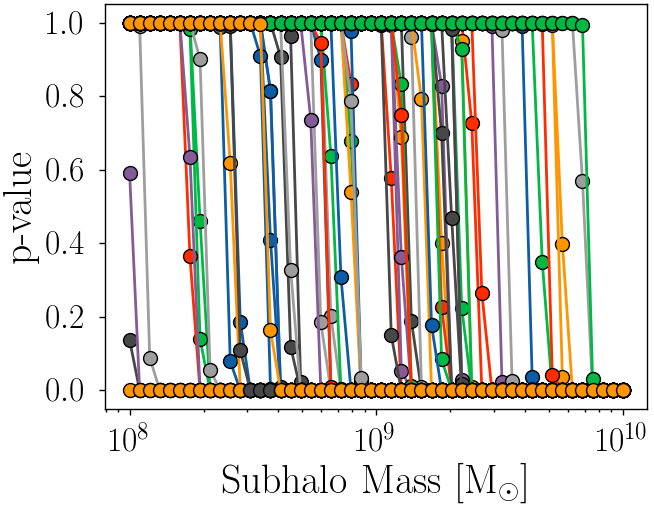

In [68]:
sample_position_key = list(results[0].keys())[0]

for i, result in enumerate(results):
    sample_results = result[sample_position_key]

    mass_list, median_list, maxes, mins = [], [], [], []
    for mass, chi_squared_list in sample_results.items():
        p_list = [rv.sf(chi) for chi in chi_squared_list]
        mass_list.append(mass)
        median_list.append(np.median(p_list))
        maxes.append(np.max(p_list))
        mins.append(np.min(p_list))
        uplims = np.array(maxes) - np.array(median_list)
        lolims = np.array(median_list) - np.array(mins)
    
    if p_list[-1] == 1.:
        print('Skipping lens', i + 1)
        results.remove(result)
        continue

    mass_list = [float(mass) for mass in mass_list]
    plt.errorbar(mass_list, median_list, yerr=[lolims, uplims], fmt='o', label=f'Lens {i + 1}', ls='-')
plt.xlabel('Subhalo Mass [M$_\odot$]')
plt.ylabel('p-value')
plt.xscale('log')
# plt.yscale('log')
# plt.legend()
plt.savefig(os.path.join(figure_dir, 'ldsm_04_p_vals.png'))
plt.show()

In [69]:
sides = 4

positions = []
for i in range(1, 19):
    sca = str(i).zfill(2)
    coords = Roman().divide_up_sca(sides)
    for coord in coords:
        positions.append((sca, coord))

masses = np.logspace(8, 10, 50)

lens_array_list = []
error_list = []

for k, result in tqdm(enumerate(results), total=len(results)):
    # print(f'Result {k + 1} of {len(results)}')
    current_sca = 1
    array_list = []

    # initialize the array and mass list
    array = np.zeros((sides, sides))
    mass_list = []

    for sca, sca_position in positions:
        position_key = f'{int(sca)}_{sca_position[0]}_{sca_position[1]}'
        position_results = result[position_key]

        for mass in masses:
            chi2_list = position_results[str(int(mass))]
            p_list = [rv.sf(chi) for chi in chi2_list]
            mass = float(mass)
            if np.min(p_list) < pval_threshold:
                # print(f'hit threshold at {mass:.2e}')
                mass_list.append(mass)
                break

        # if the last position has been reached, populate the array with the masses
        if sca_position == coords[-1]:  
            for i in range(sides):
                for j in range(sides):
                    try:
                        array[i, j] = mass_list[j * sides + i]
                    except Exception as e:
                        error_list.append(k)
                        # print(k)
            array_list.append(array)

            # reset the array and mass list
            array = np.zeros((sides, sides))
            mass_list = []
    
    lens_array_list.append(array_list)

print(error_list)
# plt.imshow(array_list[0], cmap='viridis')
# plt.colorbar()
# plt.show()

100%|██████████| 83/83 [01:16<00:00,  1.08it/s]

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55,

In [70]:
for k, result in tqdm(enumerate(results), total=len(results)):
    if k in error_list:
        print(f'Skipping lens {k + 1}')
        continue
    else:
        print(f'Result {k + 1} of {len(results)}')
    current_sca = 1
    array_list = []

    # initialize the array and mass list
    array = np.zeros((sides, sides))
    mass_list = []

    for sca, sca_position in positions:
        position_key = f'{int(sca)}_{sca_position[0]}_{sca_position[1]}'
        position_results = result[position_key]

        for mass in masses:
            chi2_list = position_results[str(int(mass))]
            p_list = [rv.sf(chi) for chi in chi2_list]
            mass = float(mass)
            if np.min(p_list) < pval_threshold:
                # print(f'hit threshold at {mass:.2e}')
                mass_list.append(mass)
                break

        # if the last position has been reached, populate the array with the masses
        if sca_position == coords[-1]:  
            for i in range(sides):
                for j in range(sides):
                    try:
                        array[i, j] = mass_list[j * sides + i]
                    except Exception as e:
                        error_list.append(k)
                        print(k)
            array_list.append(array)

            # reset the array and mass list
            array = np.zeros((sides, sides))
            mass_list = []
    
    lens_array_list.append(array_list)

0it [00:00, ?it/s]

Result 1 of 83


1it [00:00,  1.76it/s]

Result 2 of 83


2it [00:02,  1.10s/it]

Result 3 of 83


3it [00:03,  1.30s/it]

Result 4 of 83


5it [00:05,  1.08it/s]

Result 5 of 83
Skipping lens 6
Result 7 of 83


8it [00:05,  2.46it/s]

Result 8 of 83
Result 9 of 83


10it [00:06,  2.37it/s]

Result 10 of 83
Result 11 of 83


11it [00:07,  1.56it/s]

Result 12 of 83


12it [00:09,  1.10it/s]

Result 13 of 83


13it [00:10,  1.02s/it]

Result 14 of 83


14it [00:10,  1.12it/s]

Result 15 of 83


15it [00:12,  1.02s/it]

Result 16 of 83


17it [00:13,  1.14it/s]

Result 17 of 83
Result 18 of 83


18it [00:15,  1.05s/it]

Result 19 of 83


19it [00:15,  1.02it/s]

Result 20 of 83


20it [00:16,  1.09it/s]

Result 21 of 83


21it [00:18,  1.10s/it]

Result 22 of 83


22it [00:19,  1.11s/it]

Result 23 of 83


23it [00:20,  1.07s/it]

Result 24 of 83


25it [00:21,  1.22it/s]

Result 25 of 83
Result 26 of 83


28it [00:23,  1.38it/s]

Result 27 of 83
Result 28 of 83


29it [00:24,  1.39it/s]

Result 29 of 83
Result 30 of 83


31it [00:26,  1.24it/s]

Result 31 of 83
Result 32 of 83


32it [00:27,  1.19it/s]

Result 33 of 83


33it [00:28,  1.03it/s]

Result 34 of 83


34it [00:29,  1.06s/it]

Result 35 of 83


35it [00:30,  1.12s/it]

Result 36 of 83


38it [00:33,  1.19it/s]

Result 37 of 83
Result 38 of 83


40it [00:35,  1.27it/s]

Result 39 of 83
Result 40 of 83


41it [00:35,  1.56it/s]

Result 41 of 83
Result 42 of 83


42it [00:36,  1.27it/s]

Result 43 of 83


43it [00:37,  1.04it/s]

Result 44 of 83


44it [00:38,  1.02it/s]

Result 45 of 83


46it [00:40,  1.04it/s]

Result 46 of 83
Result 47 of 83


47it [00:42,  1.05s/it]

Result 48 of 83


49it [00:43,  1.06it/s]

Result 49 of 83
Result 50 of 83


50it [00:44,  1.06s/it]

Result 51 of 83


51it [00:46,  1.08s/it]

Result 52 of 83


52it [00:47,  1.26s/it]

Skipping lens 53
Result 54 of 83


55it [00:49,  1.27it/s]

Result 55 of 83
Skipping lens 56
Result 57 of 83


57it [00:50,  1.55it/s]

Result 58 of 83


58it [00:51,  1.24it/s]

Skipping lens 59
Result 60 of 83


60it [00:52,  1.53it/s]

Result 61 of 83


61it [00:53,  1.25it/s]

Result 62 of 83


62it [00:54,  1.08it/s]

Result 63 of 83


64it [00:56,  1.18it/s]

Result 64 of 83
Result 65 of 83


65it [00:57,  1.07it/s]

Skipping lens 66
Skipping lens 67
Result 68 of 83


68it [00:58,  1.63it/s]

Result 69 of 83


69it [00:59,  1.74it/s]

Result 70 of 83


70it [01:00,  1.37it/s]

Result 71 of 83


72it [01:01,  1.41it/s]

Result 72 of 83
Result 73 of 83


73it [01:03,  1.05it/s]

Result 74 of 83


74it [01:04,  1.07it/s]

Result 75 of 83


75it [01:05,  1.01it/s]

Result 76 of 83


76it [01:06,  1.04s/it]

Result 77 of 83


77it [01:07,  1.05s/it]

Result 78 of 83


78it [01:08,  1.04it/s]

Result 79 of 83


79it [01:09,  1.06s/it]

Result 80 of 83


80it [01:10,  1.02s/it]

Result 81 of 83


81it [01:11,  1.05s/it]

Result 82 of 83


82it [01:13,  1.22s/it]

Result 83 of 83


83it [01:14,  1.12it/s]


In [71]:
# for i, _ in enumerate(results):
#     plotting.roman_sca_plot(np.asarray(lens_array_list[i]), 
#                             np.asarray(range(1, 19)), 
#                             residual_plot=False, 
#                             show_sca_id=False, 
#                             cmap='viridis_r', 
#                             savefig=False, 
#                             savepath=None,  # os.path.join(figure_dir, 'lowest_detectable_subhalo_mass_single_system.png') 
#                             clabel=r'Lowest detectable subhalo mass [M$_\odot$]')

In [72]:
median_array_list = []

for sca in range(1, 19):
    array = np.zeros((sides, sides))

    for i in range(sides):
            for j in range(sides):
                pixel_values = []
                for lens_array in lens_array_list:
                    pixel_values.append(lens_array[sca - 1][i, j])
                median = np.mean(pixel_values)
                array[i, j] = median
    
    median_array_list.append(array)

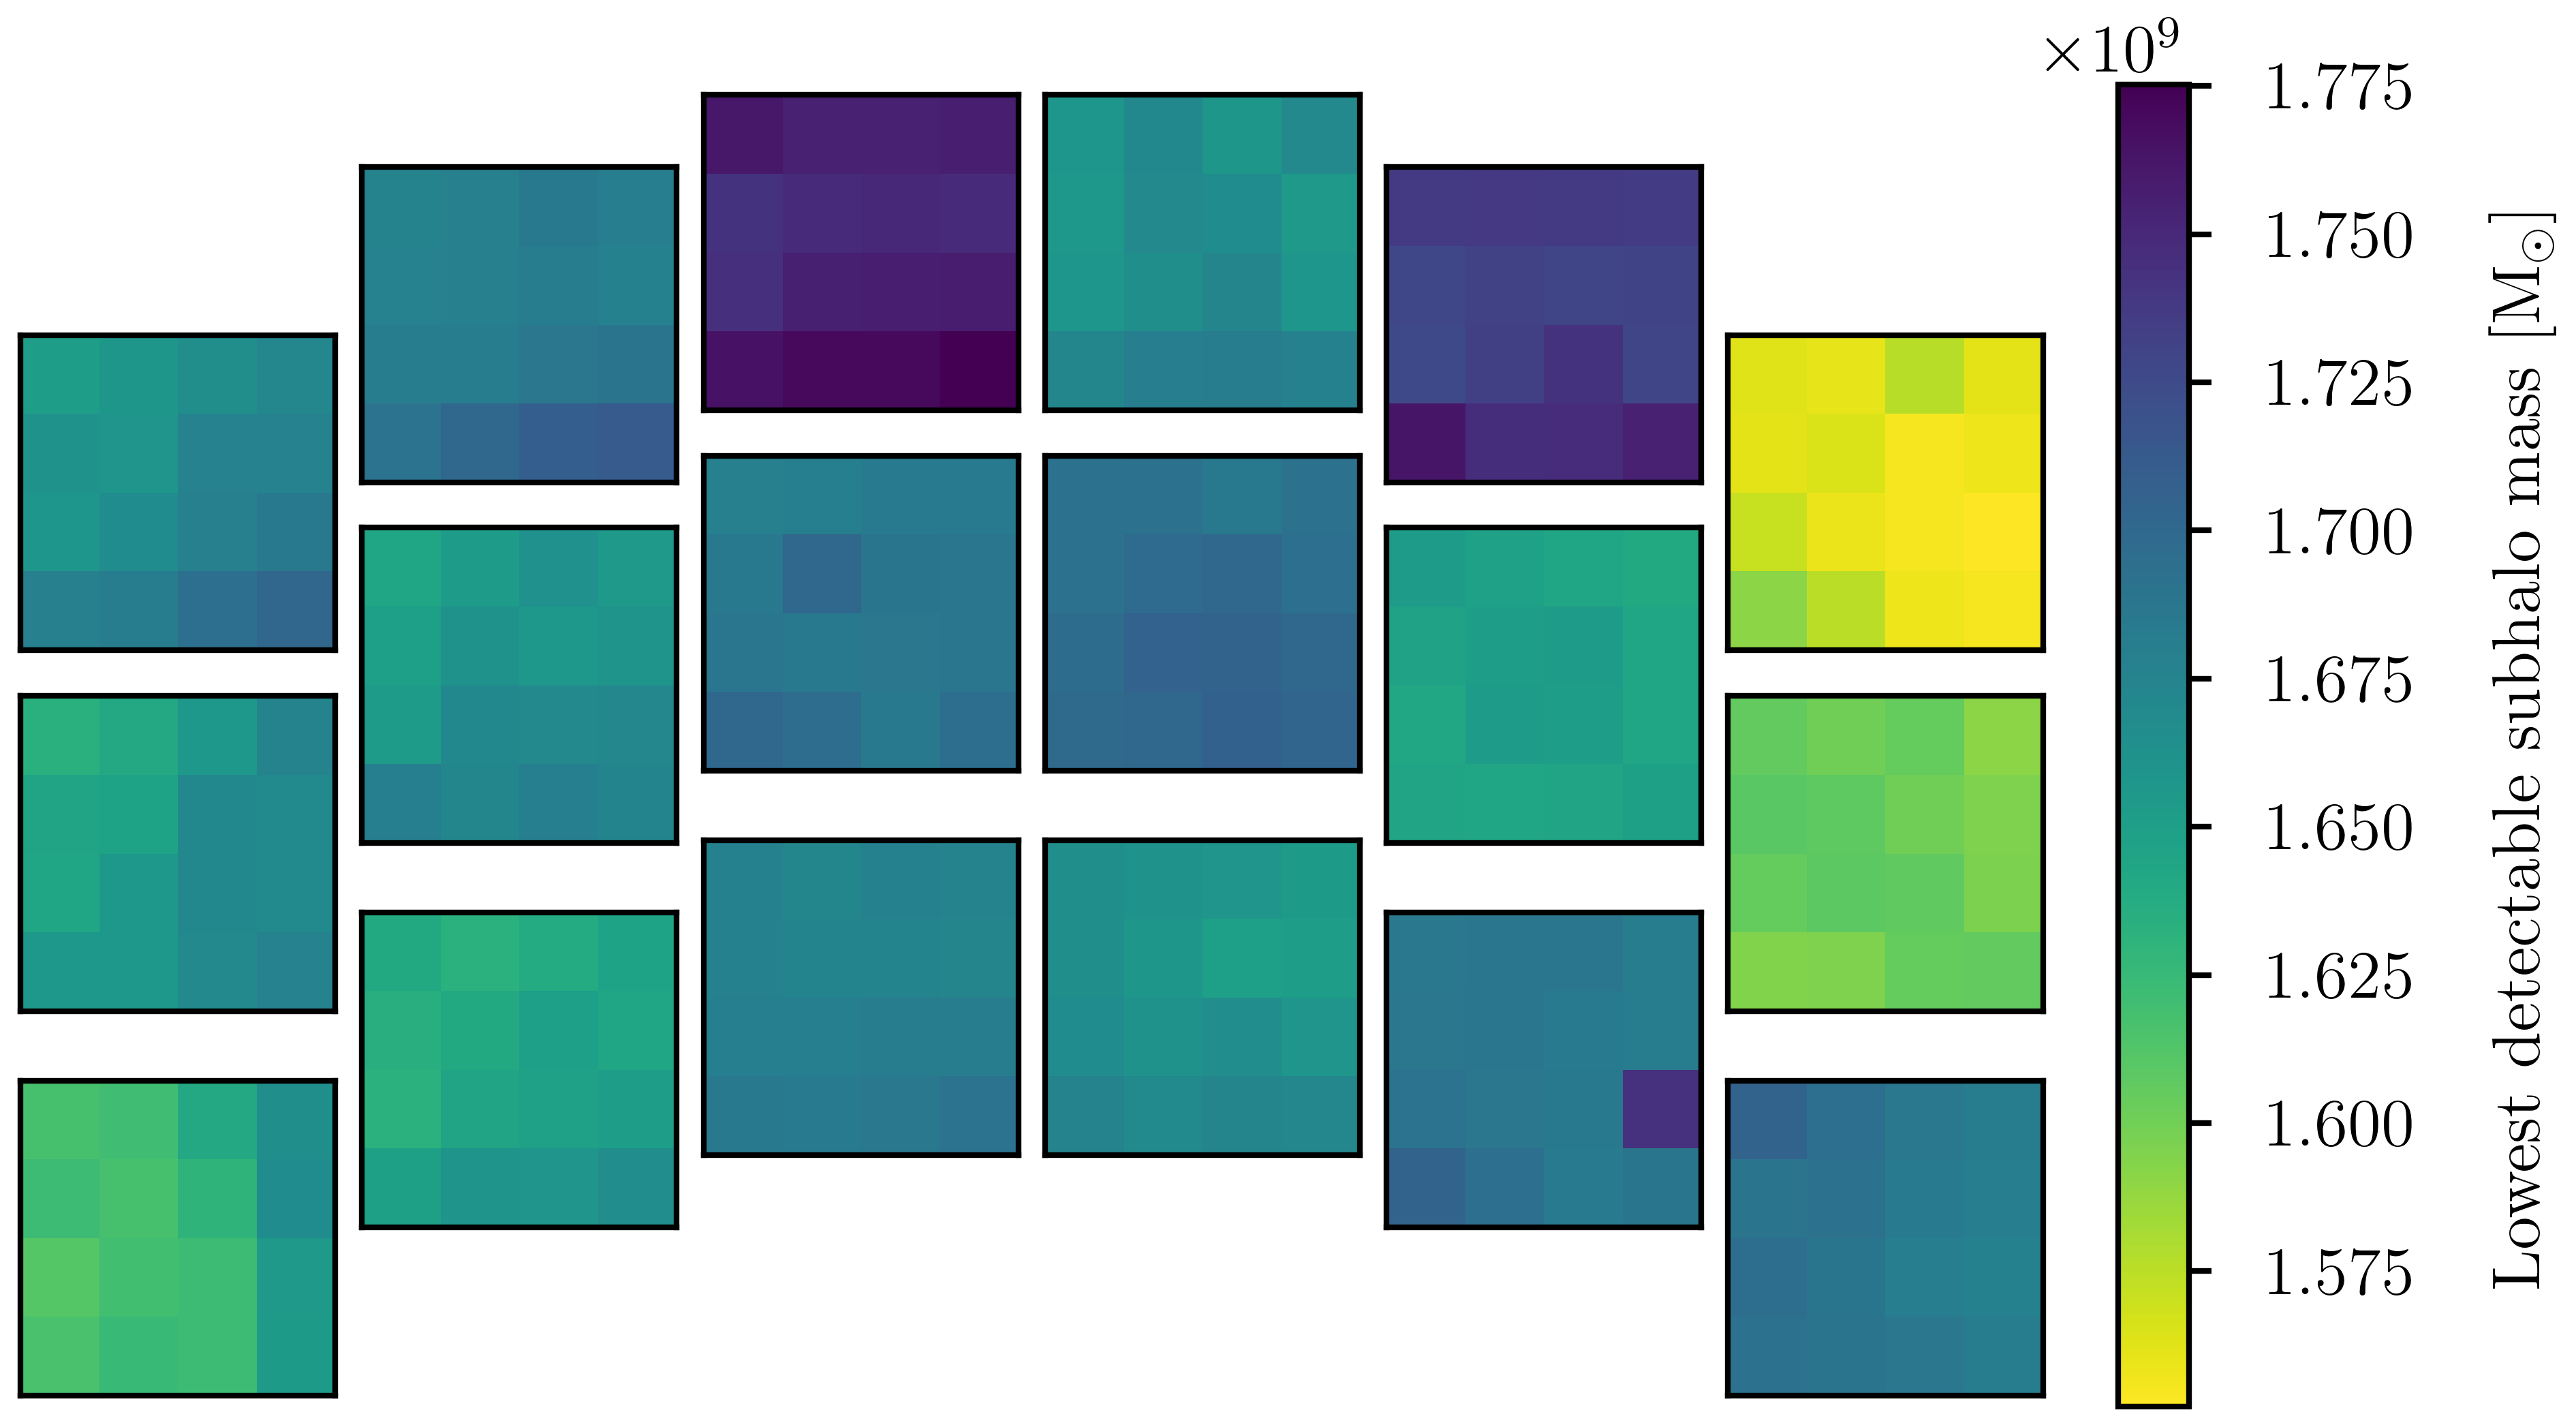

In [74]:
plotting.roman_sca_plot(np.asarray(median_array_list), 
                        np.asarray(range(1, 19)), 
                        residual_plot=False, 
                        show_sca_id=False, 
                        cmap='viridis_r', 
                        savefig=True, 
                        savepath=os.path.join(figure_dir, 'lowest_detectable_subhalo_mass.png'), 
                        clabel=r'Lowest detectable subhalo mass [M$_\odot$]')